In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import xgboost as xgb
import shap
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.metrics import mean_squared_error

from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe


In [23]:
DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/raw_data/datasets/raw_data_raw_data.parquet.gzip'
processor_pipe = (ClassifierPipe(DATA_PATH)
             .read_raw_data()
             .calculate_max_min_signal()
             .calculate_percent_avoid()
             .drop_features(["event", "action", "trial", "trial_count", "num_avoids", "max_trial"])
             .split_data(test_size=0.2,
                test_dev_size=0.5, 
                split_group = "mouse_id", 
                stratify_group = "sex", 
                target='ratio_avoid',
                save_subject_ids=False)
                # path_to_save =os.path.dirname(raw_path)
            .transform_data()
)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'

In [ ]:

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                            #  n_estimators = 100, 
                            #  max_depth =3,
                            #  learning_rate = .01,
                            # #  min_child_weight = 3,
                             eval_metric=['rmse', 'mae']
                            )
xgb_model.fit(processor_pipe.X_train, processor_pipe.y_train, eval_set = [(processor_pipe.X_dev, processor_pipe.y_dev)])

[0]	validation_0-rmse:0.26426	validation_0-mae:0.24717
[1]	validation_0-rmse:0.29253	validation_0-mae:0.27971
[2]	validation_0-rmse:0.30943	validation_0-mae:0.29927
[3]	validation_0-rmse:0.32130	validation_0-mae:0.31289
[4]	validation_0-rmse:0.33102	validation_0-mae:0.32301
[5]	validation_0-rmse:0.33335	validation_0-mae:0.32645
[6]	validation_0-rmse:0.34066	validation_0-mae:0.33406
[7]	validation_0-rmse:0.34362	validation_0-mae:0.33731
[8]	validation_0-rmse:0.34342	validation_0-mae:0.33763
[9]	validation_0-rmse:0.34583	validation_0-mae:0.34020
[10]	validation_0-rmse:0.34685	validation_0-mae:0.34140
[11]	validation_0-rmse:0.34668	validation_0-mae:0.34111
[12]	validation_0-rmse:0.34659	validation_0-mae:0.34104
[13]	validation_0-rmse:0.34678	validation_0-mae:0.34133
[14]	validation_0-rmse:0.34690	validation_0-mae:0.34140
[15]	validation_0-rmse:0.34709	validation_0-mae:0.34156
[16]	validation_0-rmse:0.34733	validation_0-mae:0.34172
[17]	validation_0-rmse:0.34753	validation_0-mae:0.34192
[1

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


[94]	validation_0-rmse:0.34761	validation_0-mae:0.34183
[95]	validation_0-rmse:0.34761	validation_0-mae:0.34183
[96]	validation_0-rmse:0.34763	validation_0-mae:0.34182
[97]	validation_0-rmse:0.34765	validation_0-mae:0.34183
[98]	validation_0-rmse:0.34765	validation_0-mae:0.34183
[99]	validation_0-rmse:0.34765	validation_0-mae:0.34183


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse', 'mae'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_model.score(processor_pipe.X_test, processor_pipe.y_test)

0.48226359531489293

In [ ]:
num_cols = processor_pipe.processor.named_transformers_["num"].get_feature_names_out().tolist()
cat_cols = processor_pipe.processor.named_transformers_["cat"].get_feature_names_out().tolist()
cols = num_cols + cat_cols
xgb_model.feature_importances_
cols[1]

'day'



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



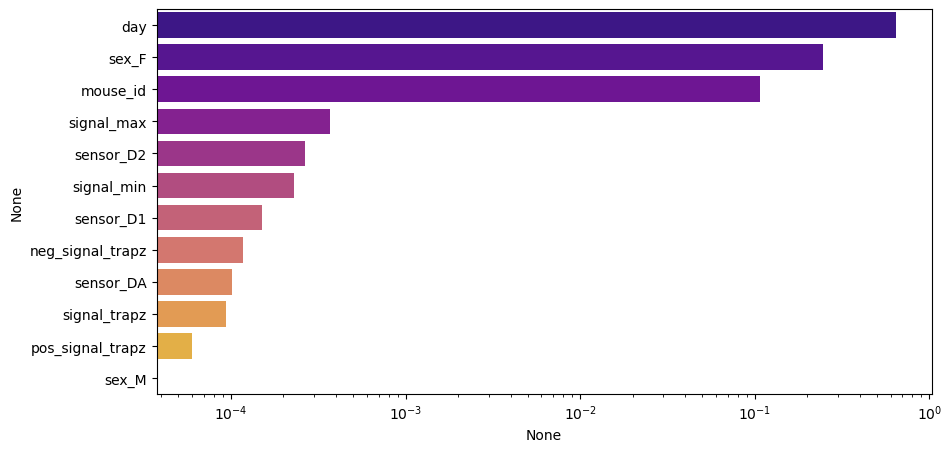

In [ ]:
feature_importance = pd.Series(xgb_model.feature_importances_, index=cols).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(x=feature_importance, y = feature_importance.index, palette='plasma')
ax.set_xscale('log')


In [ ]:
prediction = xgb_model.predict(processor_pipe.X_test)
shap_ex = shap.TreeExplainer(xgb_model)
explanation = shap_ex(processor_pipe.X_test)
shap_values = explanation.values
np.abs(shap_values.sum(axis=1) + explanation.base_values - prediction).max()
0.0

[14:40:26] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


0.0

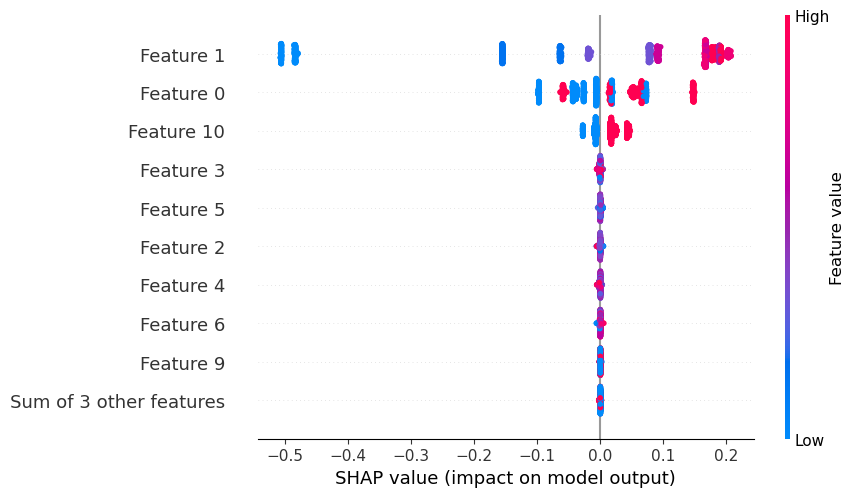

In [ ]:
shap.plots.beeswarm(explanation)

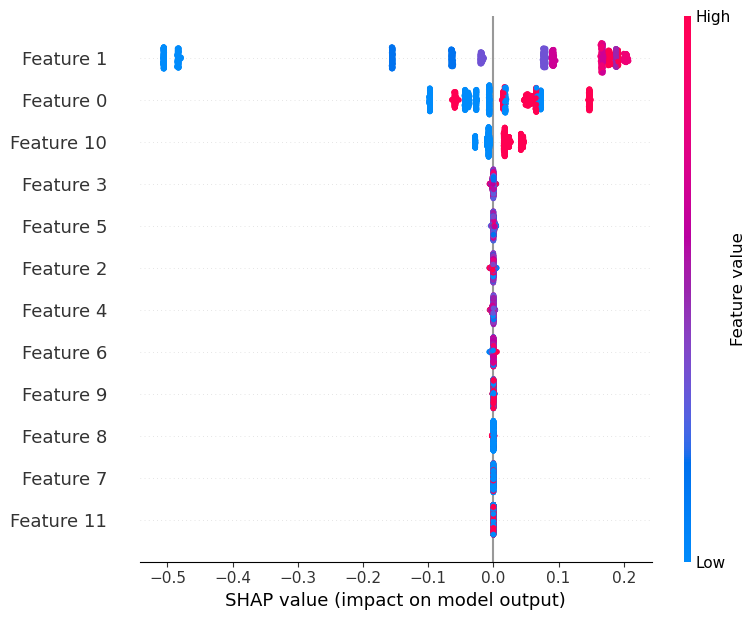

In [ ]:
shap.summary_plot(shap_values, processor_pipe.X_test)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
shap_pca = PCA(n_components=3).fit_transform(shap_values)

In [ ]:
shap_pca
from matplotlib.colors import LinearSegmentedColormap

cdict1 = {
    "red": (
        (0.0, 0.11764705882352941, 0.11764705882352941),
        (1.0, 0.9607843137254902, 0.9607843137254902),
    ),
    "green": (
        (0.0, 0.5333333333333333, 0.5333333333333333),
        (1.0, 0.15294117647058825, 0.15294117647058825),
    ),
    "blue": (
        (0.0, 0.8980392156862745, 0.8980392156862745),
        (1.0, 0.3411764705882353, 0.3411764705882353),
    ),
    "alpha": ((0.0, 1, 1), (0.5, 1, 1), (1.0, 1, 1)),
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap("RedBlue", cdict1)

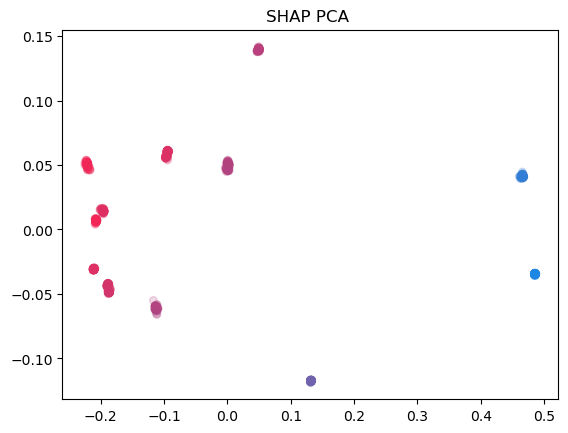

In [ ]:
plt.scatter(shap_pca[:,0], shap_pca[:,1],s = 30,  c = shap_values.sum(1).astype(float), cmap=red_blue_solid, alpha=0.2)
plt.title("SHAP PCA ")
plt.show()

In [ ]:
shap_embeddings = TSNE(n_components = 2).fit_transform(shap_values)

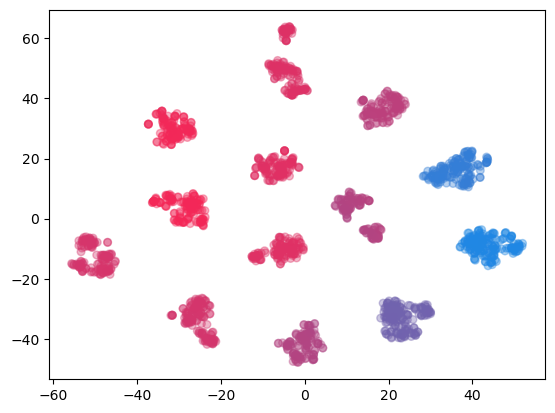

In [ ]:
plt.scatter(shap_embeddings[:,0], shap_embeddings[:,1],s = 30,  c = shap_values.sum(1).astype(float), cmap=red_blue_solid, alpha=0.2)
plt.show()